In [1]:
import feature_extraction as fe

import numpy as np

import os
import random
import pickle
import warnings
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 3
random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [2]:
def data_batcher(data, batch_size):
    random.shuffle(data)
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

In [3]:
dataset = 'FMA_small'
new_feats = False


dataset_filename = f'../datasets/{dataset}.gui'
pickle_filename = f'./feats_spects-pickles/{dataset_filename.split("/")[-1][:-4]}_feats.pkl'
if new_feats or not os.path.isfile(pickle_filename):
    feats, labels = fe.extract_numfeats(dataset_filename)
    with open(pickle_filename, 'wb') as f:
        pickle.dump([feats, labels], f)
else:
    with open(pickle_filename, 'rb') as f:
        feats, labels = pickle.load(f)
    print(f'{feats.shape[0]} features extracted')

7995 features extracted


In [4]:
scaler = StandardScaler()
scaled_feats = scaler.fit_transform(feats)

x_trainval, x_test, y_trainval, y_test = train_test_split(scaled_feats, labels, test_size=1/10) # NO TOCAR!
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=1/9)        # NO TOCAR!

train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
test_data = [(x, y) for x, y in zip(x_test, y_test)]

print(len(train_data), "training samples")
print(len(val_data), "validation samples")
print(len(test_data), "test samples")

6395 training samples
800 validation samples
800 test samples


In [5]:
# Fully connected neural network with one hidden layer
class DNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DNNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = nn.Linear(hidden_size[2], hidden_size[3])
        self.fc5 = nn.Linear(hidden_size[3], num_classes)
        
        self.bn2 = nn.BatchNorm1d(hidden_size[1])
        self.bn3 = nn.BatchNorm1d(hidden_size[2])
        self.bn4 = nn.BatchNorm1d(hidden_size[3])
        
        self.drop_layer = nn.Dropout(p=0.25)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop_layer(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop_layer(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.drop_layer(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.fc5(x)
        return x # we can return here the softmax, but then we should use the nll_loss instead of the cross_entropy

In [6]:
def train(log_interval, model, device, data_batches, optimizer, epoch):
    losses = []
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.train()
    
    for i, batch in enumerate(data_batches):
        x, y = list(zip(*batch))
        
        # Move tensors to the configured device
        data = torch.from_numpy(np.array(x)).float().to(device)
        target = torch.from_numpy(np.array(y)).to(device)
        
        # clear all the gradients of the optimized tensors
        optimizer.zero_grad()
    
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (i+1) % log_interval == 0:
            print(f'Train Epoch: {epoch+1} [{str((i+1)*len(data)).zfill((len(str(len_glob_data))))}/{len_glob_data} ({str(int(100. * (i+1)*len(data) / len_glob_data)).zfill(2)}%)]\tLoss: {round(loss.item(),6)}')
    return np.array(losses).mean()

In [7]:
def validate(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = []
    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            validation_loss.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss = np.array(validation_loss).mean()
    accuracy = 100. * correct / len_glob_data

    print(f'\nValidation set: Average loss: {round(validation_loss, 4)}, Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy, validation_loss

In [8]:
def test(model, device, data_batches):
    len_glob_data = np.prod(np.array(np.array(data_batches).shape[:-1]))
    
    model.eval()  # let's put the model in evaluation mode

    correct = 0
    with torch.no_grad():  # we don't need gradient computation at all
        for i, batch in enumerate(data_batches):
            x, y = list(zip(*batch))
        
            data = torch.from_numpy(np.array(x)).float().to(device)
            target = torch.from_numpy(np.array(y)).to(device)
            
            output = model(data)
            loss = criterion(output, target)
            
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len_glob_data

    print(f'Test set: Accuracy: {correct}/{len_glob_data} ({int(accuracy)}%)\n')
    
    return accuracy

In [9]:
# Hyperparameters

input_size = 25
hidden_size = [256, 128, 64, 32]
num_classes = 10

train_batch_size = 5 # NO TOCAR!
valid_batch_size = 100

num_epochs = 600
learning_rate = 0.0001

In [10]:
train_data_batches = data_batcher(train_data, train_batch_size)
val_data_batches = data_batcher(val_data, valid_batch_size)

model = DNNClassifier(input_size, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []
accuracies = []

for epoch in range(num_epochs):
    
    train_loss = train(200, model, device, train_data_batches, optimizer, epoch)
    train_losses.append(train_loss)

    accuracy, valid_loss = validate(model, device, val_data_batches)
    valid_losses.append(valid_loss)
    accuracies.append(accuracy)

Train Epoch: 1 [1000/6395 (15%)]	Loss: 2.327974
Train Epoch: 1 [2000/6395 (31%)]	Loss: 2.174224
Train Epoch: 1 [3000/6395 (46%)]	Loss: 2.073103
Train Epoch: 1 [4000/6395 (62%)]	Loss: 2.234803
Train Epoch: 1 [5000/6395 (78%)]	Loss: 2.185905
Train Epoch: 1 [6000/6395 (93%)]	Loss: 1.978382

Validation set: Average loss: 2.0984, Accuracy: 238/800 (29%)

Train Epoch: 2 [1000/6395 (15%)]	Loss: 2.227801
Train Epoch: 2 [2000/6395 (31%)]	Loss: 1.965638
Train Epoch: 2 [3000/6395 (46%)]	Loss: 1.760823
Train Epoch: 2 [4000/6395 (62%)]	Loss: 2.09755
Train Epoch: 2 [5000/6395 (78%)]	Loss: 2.116078
Train Epoch: 2 [6000/6395 (93%)]	Loss: 2.044445

Validation set: Average loss: 1.9531, Accuracy: 272/800 (34%)

Train Epoch: 3 [1000/6395 (15%)]	Loss: 2.168875
Train Epoch: 3 [2000/6395 (31%)]	Loss: 1.992676
Train Epoch: 3 [3000/6395 (46%)]	Loss: 1.452172
Train Epoch: 3 [4000/6395 (62%)]	Loss: 1.731741
Train Epoch: 3 [5000/6395 (78%)]	Loss: 2.072387
Train Epoch: 3 [6000/6395 (93%)]	Loss: 1.796354

Validati

Train Epoch: 24 [2000/6395 (31%)]	Loss: 0.964461
Train Epoch: 24 [3000/6395 (46%)]	Loss: 0.821157
Train Epoch: 24 [4000/6395 (62%)]	Loss: 1.770675
Train Epoch: 24 [5000/6395 (78%)]	Loss: 1.036344
Train Epoch: 24 [6000/6395 (93%)]	Loss: 1.394657

Validation set: Average loss: 1.6055, Accuracy: 336/800 (42%)

Train Epoch: 25 [1000/6395 (15%)]	Loss: 1.362027
Train Epoch: 25 [2000/6395 (31%)]	Loss: 1.105637
Train Epoch: 25 [3000/6395 (46%)]	Loss: 0.725973
Train Epoch: 25 [4000/6395 (62%)]	Loss: 2.02691
Train Epoch: 25 [5000/6395 (78%)]	Loss: 1.200297
Train Epoch: 25 [6000/6395 (93%)]	Loss: 1.407857

Validation set: Average loss: 1.5979, Accuracy: 334/800 (41%)

Train Epoch: 26 [1000/6395 (15%)]	Loss: 1.272134
Train Epoch: 26 [2000/6395 (31%)]	Loss: 0.773973
Train Epoch: 26 [3000/6395 (46%)]	Loss: 1.003451
Train Epoch: 26 [4000/6395 (62%)]	Loss: 1.510285
Train Epoch: 26 [5000/6395 (78%)]	Loss: 0.923784
Train Epoch: 26 [6000/6395 (93%)]	Loss: 1.284238

Validation set: Average loss: 1.5866, A

Train Epoch: 47 [2000/6395 (31%)]	Loss: 0.715088
Train Epoch: 47 [3000/6395 (46%)]	Loss: 1.296127
Train Epoch: 47 [4000/6395 (62%)]	Loss: 1.547322
Train Epoch: 47 [5000/6395 (78%)]	Loss: 1.276663
Train Epoch: 47 [6000/6395 (93%)]	Loss: 1.262125

Validation set: Average loss: 1.5567, Accuracy: 353/800 (44%)

Train Epoch: 48 [1000/6395 (15%)]	Loss: 1.317042
Train Epoch: 48 [2000/6395 (31%)]	Loss: 1.113745
Train Epoch: 48 [3000/6395 (46%)]	Loss: 0.975239
Train Epoch: 48 [4000/6395 (62%)]	Loss: 2.114095
Train Epoch: 48 [5000/6395 (78%)]	Loss: 1.014053
Train Epoch: 48 [6000/6395 (93%)]	Loss: 1.364907

Validation set: Average loss: 1.5458, Accuracy: 358/800 (44%)

Train Epoch: 49 [1000/6395 (15%)]	Loss: 0.906805
Train Epoch: 49 [2000/6395 (31%)]	Loss: 0.793762
Train Epoch: 49 [3000/6395 (46%)]	Loss: 0.778883
Train Epoch: 49 [4000/6395 (62%)]	Loss: 1.449217
Train Epoch: 49 [5000/6395 (78%)]	Loss: 1.113309
Train Epoch: 49 [6000/6395 (93%)]	Loss: 1.377007

Validation set: Average loss: 1.5415, 

Train Epoch: 70 [2000/6395 (31%)]	Loss: 0.839159
Train Epoch: 70 [3000/6395 (46%)]	Loss: 0.981106
Train Epoch: 70 [4000/6395 (62%)]	Loss: 1.571144
Train Epoch: 70 [5000/6395 (78%)]	Loss: 0.794978
Train Epoch: 70 [6000/6395 (93%)]	Loss: 1.190373

Validation set: Average loss: 1.5317, Accuracy: 367/800 (45%)

Train Epoch: 71 [1000/6395 (15%)]	Loss: 0.737975
Train Epoch: 71 [2000/6395 (31%)]	Loss: 0.774299
Train Epoch: 71 [3000/6395 (46%)]	Loss: 0.483284
Train Epoch: 71 [4000/6395 (62%)]	Loss: 1.543382
Train Epoch: 71 [5000/6395 (78%)]	Loss: 0.962774
Train Epoch: 71 [6000/6395 (93%)]	Loss: 1.584157

Validation set: Average loss: 1.5484, Accuracy: 357/800 (44%)

Train Epoch: 72 [1000/6395 (15%)]	Loss: 1.053715
Train Epoch: 72 [2000/6395 (31%)]	Loss: 0.701752
Train Epoch: 72 [3000/6395 (46%)]	Loss: 1.182985
Train Epoch: 72 [4000/6395 (62%)]	Loss: 1.212118
Train Epoch: 72 [5000/6395 (78%)]	Loss: 0.571067
Train Epoch: 72 [6000/6395 (93%)]	Loss: 1.126473

Validation set: Average loss: 1.5381, 

Train Epoch: 93 [2000/6395 (31%)]	Loss: 0.509655
Train Epoch: 93 [3000/6395 (46%)]	Loss: 0.86974
Train Epoch: 93 [4000/6395 (62%)]	Loss: 1.314573
Train Epoch: 93 [5000/6395 (78%)]	Loss: 0.737232
Train Epoch: 93 [6000/6395 (93%)]	Loss: 1.241158

Validation set: Average loss: 1.5564, Accuracy: 354/800 (44%)

Train Epoch: 94 [1000/6395 (15%)]	Loss: 1.096465
Train Epoch: 94 [2000/6395 (31%)]	Loss: 0.702587
Train Epoch: 94 [3000/6395 (46%)]	Loss: 0.962498
Train Epoch: 94 [4000/6395 (62%)]	Loss: 1.67951
Train Epoch: 94 [5000/6395 (78%)]	Loss: 0.955998
Train Epoch: 94 [6000/6395 (93%)]	Loss: 1.226238

Validation set: Average loss: 1.5459, Accuracy: 369/800 (46%)

Train Epoch: 95 [1000/6395 (15%)]	Loss: 0.975275
Train Epoch: 95 [2000/6395 (31%)]	Loss: 0.615724
Train Epoch: 95 [3000/6395 (46%)]	Loss: 0.686415
Train Epoch: 95 [4000/6395 (62%)]	Loss: 1.009092
Train Epoch: 95 [5000/6395 (78%)]	Loss: 0.909349
Train Epoch: 95 [6000/6395 (93%)]	Loss: 0.991909

Validation set: Average loss: 1.5449, Ac


Validation set: Average loss: 1.5585, Accuracy: 354/800 (44%)

Train Epoch: 116 [1000/6395 (15%)]	Loss: 0.825971
Train Epoch: 116 [2000/6395 (31%)]	Loss: 0.436076
Train Epoch: 116 [3000/6395 (46%)]	Loss: 0.673025
Train Epoch: 116 [4000/6395 (62%)]	Loss: 1.175753
Train Epoch: 116 [5000/6395 (78%)]	Loss: 0.926582
Train Epoch: 116 [6000/6395 (93%)]	Loss: 1.12924

Validation set: Average loss: 1.5422, Accuracy: 364/800 (45%)

Train Epoch: 117 [1000/6395 (15%)]	Loss: 1.228005
Train Epoch: 117 [2000/6395 (31%)]	Loss: 0.870691
Train Epoch: 117 [3000/6395 (46%)]	Loss: 0.838568
Train Epoch: 117 [4000/6395 (62%)]	Loss: 1.07991
Train Epoch: 117 [5000/6395 (78%)]	Loss: 0.641604
Train Epoch: 117 [6000/6395 (93%)]	Loss: 1.203444

Validation set: Average loss: 1.5521, Accuracy: 354/800 (44%)

Train Epoch: 118 [1000/6395 (15%)]	Loss: 1.057212
Train Epoch: 118 [2000/6395 (31%)]	Loss: 0.51421
Train Epoch: 118 [3000/6395 (46%)]	Loss: 1.167696
Train Epoch: 118 [4000/6395 (62%)]	Loss: 1.295239
Train Epoch

Train Epoch: 138 [4000/6395 (62%)]	Loss: 1.819617
Train Epoch: 138 [5000/6395 (78%)]	Loss: 1.129506
Train Epoch: 138 [6000/6395 (93%)]	Loss: 1.008121

Validation set: Average loss: 1.5641, Accuracy: 352/800 (44%)

Train Epoch: 139 [1000/6395 (15%)]	Loss: 0.746346
Train Epoch: 139 [2000/6395 (31%)]	Loss: 0.685735
Train Epoch: 139 [3000/6395 (46%)]	Loss: 0.607904
Train Epoch: 139 [4000/6395 (62%)]	Loss: 1.905009
Train Epoch: 139 [5000/6395 (78%)]	Loss: 1.180686
Train Epoch: 139 [6000/6395 (93%)]	Loss: 1.070417

Validation set: Average loss: 1.5717, Accuracy: 347/800 (43%)

Train Epoch: 140 [1000/6395 (15%)]	Loss: 1.350426
Train Epoch: 140 [2000/6395 (31%)]	Loss: 0.403708
Train Epoch: 140 [3000/6395 (46%)]	Loss: 0.992995
Train Epoch: 140 [4000/6395 (62%)]	Loss: 1.351406
Train Epoch: 140 [5000/6395 (78%)]	Loss: 0.853841
Train Epoch: 140 [6000/6395 (93%)]	Loss: 0.785049

Validation set: Average loss: 1.586, Accuracy: 336/800 (42%)

Train Epoch: 141 [1000/6395 (15%)]	Loss: 0.852453
Train Epo

Train Epoch: 161 [1000/6395 (15%)]	Loss: 0.957732
Train Epoch: 161 [2000/6395 (31%)]	Loss: 1.221556
Train Epoch: 161 [3000/6395 (46%)]	Loss: 0.950538
Train Epoch: 161 [4000/6395 (62%)]	Loss: 1.018975
Train Epoch: 161 [5000/6395 (78%)]	Loss: 1.19721
Train Epoch: 161 [6000/6395 (93%)]	Loss: 0.971405

Validation set: Average loss: 1.5903, Accuracy: 342/800 (42%)

Train Epoch: 162 [1000/6395 (15%)]	Loss: 0.800108
Train Epoch: 162 [2000/6395 (31%)]	Loss: 0.90828
Train Epoch: 162 [3000/6395 (46%)]	Loss: 0.547098
Train Epoch: 162 [4000/6395 (62%)]	Loss: 1.300245
Train Epoch: 162 [5000/6395 (78%)]	Loss: 0.710187
Train Epoch: 162 [6000/6395 (93%)]	Loss: 0.818019

Validation set: Average loss: 1.5812, Accuracy: 344/800 (43%)

Train Epoch: 163 [1000/6395 (15%)]	Loss: 0.769813
Train Epoch: 163 [2000/6395 (31%)]	Loss: 0.438294
Train Epoch: 163 [3000/6395 (46%)]	Loss: 0.59775
Train Epoch: 163 [4000/6395 (62%)]	Loss: 1.122169
Train Epoch: 163 [5000/6395 (78%)]	Loss: 1.111828
Train Epoch: 163 [6000/63

Train Epoch: 183 [6000/6395 (93%)]	Loss: 0.583038

Validation set: Average loss: 1.6082, Accuracy: 338/800 (42%)

Train Epoch: 184 [1000/6395 (15%)]	Loss: 0.612472
Train Epoch: 184 [2000/6395 (31%)]	Loss: 0.561271
Train Epoch: 184 [3000/6395 (46%)]	Loss: 0.92228
Train Epoch: 184 [4000/6395 (62%)]	Loss: 1.559662
Train Epoch: 184 [5000/6395 (78%)]	Loss: 0.66668
Train Epoch: 184 [6000/6395 (93%)]	Loss: 1.323875

Validation set: Average loss: 1.6274, Accuracy: 325/800 (40%)

Train Epoch: 185 [1000/6395 (15%)]	Loss: 0.981142
Train Epoch: 185 [2000/6395 (31%)]	Loss: 1.23056
Train Epoch: 185 [3000/6395 (46%)]	Loss: 0.634123
Train Epoch: 185 [4000/6395 (62%)]	Loss: 1.495831
Train Epoch: 185 [5000/6395 (78%)]	Loss: 0.805265
Train Epoch: 185 [6000/6395 (93%)]	Loss: 0.955081

Validation set: Average loss: 1.6122, Accuracy: 335/800 (41%)

Train Epoch: 186 [1000/6395 (15%)]	Loss: 0.881491
Train Epoch: 186 [2000/6395 (31%)]	Loss: 0.246667
Train Epoch: 186 [3000/6395 (46%)]	Loss: 0.83006
Train Epoch:

Train Epoch: 206 [3000/6395 (46%)]	Loss: 0.538368
Train Epoch: 206 [4000/6395 (62%)]	Loss: 1.476288
Train Epoch: 206 [5000/6395 (78%)]	Loss: 0.842704
Train Epoch: 206 [6000/6395 (93%)]	Loss: 0.627519

Validation set: Average loss: 1.6084, Accuracy: 336/800 (42%)

Train Epoch: 207 [1000/6395 (15%)]	Loss: 0.920962
Train Epoch: 207 [2000/6395 (31%)]	Loss: 0.561041
Train Epoch: 207 [3000/6395 (46%)]	Loss: 1.000813
Train Epoch: 207 [4000/6395 (62%)]	Loss: 1.131243
Train Epoch: 207 [5000/6395 (78%)]	Loss: 0.92697
Train Epoch: 207 [6000/6395 (93%)]	Loss: 0.933799

Validation set: Average loss: 1.5945, Accuracy: 334/800 (41%)

Train Epoch: 208 [1000/6395 (15%)]	Loss: 0.745669
Train Epoch: 208 [2000/6395 (31%)]	Loss: 0.490047
Train Epoch: 208 [3000/6395 (46%)]	Loss: 0.702809
Train Epoch: 208 [4000/6395 (62%)]	Loss: 1.121493
Train Epoch: 208 [5000/6395 (78%)]	Loss: 0.636269
Train Epoch: 208 [6000/6395 (93%)]	Loss: 1.275043

Validation set: Average loss: 1.5974, Accuracy: 325/800 (40%)

Train Epo


Validation set: Average loss: 1.6497, Accuracy: 330/800 (41%)

Train Epoch: 229 [1000/6395 (15%)]	Loss: 1.027126
Train Epoch: 229 [2000/6395 (31%)]	Loss: 0.513198
Train Epoch: 229 [3000/6395 (46%)]	Loss: 1.142029
Train Epoch: 229 [4000/6395 (62%)]	Loss: 1.215072
Train Epoch: 229 [5000/6395 (78%)]	Loss: 0.791013
Train Epoch: 229 [6000/6395 (93%)]	Loss: 1.056117

Validation set: Average loss: 1.6354, Accuracy: 325/800 (40%)

Train Epoch: 230 [1000/6395 (15%)]	Loss: 1.161584
Train Epoch: 230 [2000/6395 (31%)]	Loss: 0.630026
Train Epoch: 230 [3000/6395 (46%)]	Loss: 1.069084
Train Epoch: 230 [4000/6395 (62%)]	Loss: 1.040071
Train Epoch: 230 [5000/6395 (78%)]	Loss: 0.64979
Train Epoch: 230 [6000/6395 (93%)]	Loss: 0.857646

Validation set: Average loss: 1.636, Accuracy: 327/800 (40%)

Train Epoch: 231 [1000/6395 (15%)]	Loss: 0.979765
Train Epoch: 231 [2000/6395 (31%)]	Loss: 0.882826
Train Epoch: 231 [3000/6395 (46%)]	Loss: 0.733273
Train Epoch: 231 [4000/6395 (62%)]	Loss: 0.883412
Train Epoc

Train Epoch: 251 [4000/6395 (62%)]	Loss: 1.563681
Train Epoch: 251 [5000/6395 (78%)]	Loss: 0.340781
Train Epoch: 251 [6000/6395 (93%)]	Loss: 1.08584

Validation set: Average loss: 1.6238, Accuracy: 339/800 (42%)

Train Epoch: 252 [1000/6395 (15%)]	Loss: 1.028952
Train Epoch: 252 [2000/6395 (31%)]	Loss: 0.428227
Train Epoch: 252 [3000/6395 (46%)]	Loss: 0.619638
Train Epoch: 252 [4000/6395 (62%)]	Loss: 1.561948
Train Epoch: 252 [5000/6395 (78%)]	Loss: 1.039019
Train Epoch: 252 [6000/6395 (93%)]	Loss: 1.29333

Validation set: Average loss: 1.6225, Accuracy: 334/800 (41%)

Train Epoch: 253 [1000/6395 (15%)]	Loss: 0.368356
Train Epoch: 253 [2000/6395 (31%)]	Loss: 0.233123
Train Epoch: 253 [3000/6395 (46%)]	Loss: 0.546445
Train Epoch: 253 [4000/6395 (62%)]	Loss: 1.047295
Train Epoch: 253 [5000/6395 (78%)]	Loss: 0.69927
Train Epoch: 253 [6000/6395 (93%)]	Loss: 0.576531

Validation set: Average loss: 1.6231, Accuracy: 347/800 (43%)

Train Epoch: 254 [1000/6395 (15%)]	Loss: 1.075848
Train Epoch

Train Epoch: 274 [1000/6395 (15%)]	Loss: 0.55906
Train Epoch: 274 [2000/6395 (31%)]	Loss: 0.722043
Train Epoch: 274 [3000/6395 (46%)]	Loss: 0.413485
Train Epoch: 274 [4000/6395 (62%)]	Loss: 1.679966
Train Epoch: 274 [5000/6395 (78%)]	Loss: 0.4073
Train Epoch: 274 [6000/6395 (93%)]	Loss: 1.08472

Validation set: Average loss: 1.6127, Accuracy: 339/800 (42%)

Train Epoch: 275 [1000/6395 (15%)]	Loss: 0.580085
Train Epoch: 275 [2000/6395 (31%)]	Loss: 0.606741
Train Epoch: 275 [3000/6395 (46%)]	Loss: 0.473598
Train Epoch: 275 [4000/6395 (62%)]	Loss: 0.726945
Train Epoch: 275 [5000/6395 (78%)]	Loss: 0.60036
Train Epoch: 275 [6000/6395 (93%)]	Loss: 1.139641

Validation set: Average loss: 1.6459, Accuracy: 327/800 (40%)

Train Epoch: 276 [1000/6395 (15%)]	Loss: 0.864108
Train Epoch: 276 [2000/6395 (31%)]	Loss: 0.450638
Train Epoch: 276 [3000/6395 (46%)]	Loss: 0.82958
Train Epoch: 276 [4000/6395 (62%)]	Loss: 0.381489
Train Epoch: 276 [5000/6395 (78%)]	Loss: 0.686123
Train Epoch: 276 [6000/6395 

Train Epoch: 296 [6000/6395 (93%)]	Loss: 0.750263

Validation set: Average loss: 1.6342, Accuracy: 326/800 (40%)

Train Epoch: 297 [1000/6395 (15%)]	Loss: 1.007519
Train Epoch: 297 [2000/6395 (31%)]	Loss: 0.794056
Train Epoch: 297 [3000/6395 (46%)]	Loss: 1.018716
Train Epoch: 297 [4000/6395 (62%)]	Loss: 0.834259
Train Epoch: 297 [5000/6395 (78%)]	Loss: 0.251797
Train Epoch: 297 [6000/6395 (93%)]	Loss: 0.695942

Validation set: Average loss: 1.6704, Accuracy: 317/800 (39%)

Train Epoch: 298 [1000/6395 (15%)]	Loss: 0.382907
Train Epoch: 298 [2000/6395 (31%)]	Loss: 0.672078
Train Epoch: 298 [3000/6395 (46%)]	Loss: 0.564591
Train Epoch: 298 [4000/6395 (62%)]	Loss: 0.478835
Train Epoch: 298 [5000/6395 (78%)]	Loss: 1.556749
Train Epoch: 298 [6000/6395 (93%)]	Loss: 0.58361

Validation set: Average loss: 1.6542, Accuracy: 310/800 (38%)

Train Epoch: 299 [1000/6395 (15%)]	Loss: 0.602621
Train Epoch: 299 [2000/6395 (31%)]	Loss: 0.208126
Train Epoch: 299 [3000/6395 (46%)]	Loss: 1.12143
Train Epoc

Train Epoch: 319 [3000/6395 (46%)]	Loss: 1.111594
Train Epoch: 319 [4000/6395 (62%)]	Loss: 0.541863
Train Epoch: 319 [5000/6395 (78%)]	Loss: 0.567997
Train Epoch: 319 [6000/6395 (93%)]	Loss: 1.099023

Validation set: Average loss: 1.6963, Accuracy: 315/800 (39%)

Train Epoch: 320 [1000/6395 (15%)]	Loss: 1.058206
Train Epoch: 320 [2000/6395 (31%)]	Loss: 0.359097
Train Epoch: 320 [3000/6395 (46%)]	Loss: 0.7192
Train Epoch: 320 [4000/6395 (62%)]	Loss: 1.078275
Train Epoch: 320 [5000/6395 (78%)]	Loss: 0.502563
Train Epoch: 320 [6000/6395 (93%)]	Loss: 1.286038

Validation set: Average loss: 1.6667, Accuracy: 328/800 (41%)

Train Epoch: 321 [1000/6395 (15%)]	Loss: 0.813923
Train Epoch: 321 [2000/6395 (31%)]	Loss: 0.17287
Train Epoch: 321 [3000/6395 (46%)]	Loss: 0.539083
Train Epoch: 321 [4000/6395 (62%)]	Loss: 1.074143
Train Epoch: 321 [5000/6395 (78%)]	Loss: 0.76106
Train Epoch: 321 [6000/6395 (93%)]	Loss: 0.42589

Validation set: Average loss: 1.6623, Accuracy: 320/800 (40%)

Train Epoch: 

Train Epoch: 342 [1000/6395 (15%)]	Loss: 0.665291
Train Epoch: 342 [2000/6395 (31%)]	Loss: 0.538816
Train Epoch: 342 [3000/6395 (46%)]	Loss: 0.96357
Train Epoch: 342 [4000/6395 (62%)]	Loss: 1.972878
Train Epoch: 342 [5000/6395 (78%)]	Loss: 0.509395
Train Epoch: 342 [6000/6395 (93%)]	Loss: 0.459915

Validation set: Average loss: 1.6698, Accuracy: 313/800 (39%)

Train Epoch: 343 [1000/6395 (15%)]	Loss: 0.411894
Train Epoch: 343 [2000/6395 (31%)]	Loss: 0.63228
Train Epoch: 343 [3000/6395 (46%)]	Loss: 1.005224
Train Epoch: 343 [4000/6395 (62%)]	Loss: 0.754805
Train Epoch: 343 [5000/6395 (78%)]	Loss: 0.89397
Train Epoch: 343 [6000/6395 (93%)]	Loss: 0.876216

Validation set: Average loss: 1.6785, Accuracy: 322/800 (40%)

Train Epoch: 344 [1000/6395 (15%)]	Loss: 0.678609
Train Epoch: 344 [2000/6395 (31%)]	Loss: 0.53889
Train Epoch: 344 [3000/6395 (46%)]	Loss: 0.362985
Train Epoch: 344 [4000/6395 (62%)]	Loss: 0.880649
Train Epoch: 344 [5000/6395 (78%)]	Loss: 0.794816
Train Epoch: 344 [6000/639

Train Epoch: 364 [6000/6395 (93%)]	Loss: 0.955013

Validation set: Average loss: 1.6811, Accuracy: 314/800 (39%)

Train Epoch: 365 [1000/6395 (15%)]	Loss: 0.882057
Train Epoch: 365 [2000/6395 (31%)]	Loss: 0.325529
Train Epoch: 365 [3000/6395 (46%)]	Loss: 0.285072
Train Epoch: 365 [4000/6395 (62%)]	Loss: 0.486722
Train Epoch: 365 [5000/6395 (78%)]	Loss: 1.01594
Train Epoch: 365 [6000/6395 (93%)]	Loss: 1.036731

Validation set: Average loss: 1.676, Accuracy: 308/800 (38%)

Train Epoch: 366 [1000/6395 (15%)]	Loss: 0.561121
Train Epoch: 366 [2000/6395 (31%)]	Loss: 0.228836
Train Epoch: 366 [3000/6395 (46%)]	Loss: 1.069239
Train Epoch: 366 [4000/6395 (62%)]	Loss: 0.571873
Train Epoch: 366 [5000/6395 (78%)]	Loss: 1.040435
Train Epoch: 366 [6000/6395 (93%)]	Loss: 0.785651

Validation set: Average loss: 1.6937, Accuracy: 322/800 (40%)

Train Epoch: 367 [1000/6395 (15%)]	Loss: 1.12805
Train Epoch: 367 [2000/6395 (31%)]	Loss: 0.270544
Train Epoch: 367 [3000/6395 (46%)]	Loss: 0.686181
Train Epoch

Train Epoch: 387 [3000/6395 (46%)]	Loss: 0.413463
Train Epoch: 387 [4000/6395 (62%)]	Loss: 1.567327
Train Epoch: 387 [5000/6395 (78%)]	Loss: 0.424204
Train Epoch: 387 [6000/6395 (93%)]	Loss: 0.779203

Validation set: Average loss: 1.6913, Accuracy: 323/800 (40%)

Train Epoch: 388 [1000/6395 (15%)]	Loss: 1.440548
Train Epoch: 388 [2000/6395 (31%)]	Loss: 0.268314
Train Epoch: 388 [3000/6395 (46%)]	Loss: 1.172801
Train Epoch: 388 [4000/6395 (62%)]	Loss: 0.39467
Train Epoch: 388 [5000/6395 (78%)]	Loss: 0.920906
Train Epoch: 388 [6000/6395 (93%)]	Loss: 0.951448

Validation set: Average loss: 1.673, Accuracy: 335/800 (41%)

Train Epoch: 389 [1000/6395 (15%)]	Loss: 0.692223
Train Epoch: 389 [2000/6395 (31%)]	Loss: 0.84963
Train Epoch: 389 [3000/6395 (46%)]	Loss: 0.525758
Train Epoch: 389 [4000/6395 (62%)]	Loss: 1.347633
Train Epoch: 389 [5000/6395 (78%)]	Loss: 0.206911
Train Epoch: 389 [6000/6395 (93%)]	Loss: 0.36903

Validation set: Average loss: 1.6696, Accuracy: 319/800 (39%)

Train Epoch:

Train Epoch: 410 [1000/6395 (15%)]	Loss: 1.475221
Train Epoch: 410 [2000/6395 (31%)]	Loss: 0.309021
Train Epoch: 410 [3000/6395 (46%)]	Loss: 0.336154
Train Epoch: 410 [4000/6395 (62%)]	Loss: 0.416038
Train Epoch: 410 [5000/6395 (78%)]	Loss: 0.787207
Train Epoch: 410 [6000/6395 (93%)]	Loss: 1.017399

Validation set: Average loss: 1.7101, Accuracy: 321/800 (40%)

Train Epoch: 411 [1000/6395 (15%)]	Loss: 1.459291
Train Epoch: 411 [2000/6395 (31%)]	Loss: 0.536783
Train Epoch: 411 [3000/6395 (46%)]	Loss: 0.36533
Train Epoch: 411 [4000/6395 (62%)]	Loss: 0.691635
Train Epoch: 411 [5000/6395 (78%)]	Loss: 0.442173
Train Epoch: 411 [6000/6395 (93%)]	Loss: 0.86689

Validation set: Average loss: 1.6771, Accuracy: 321/800 (40%)

Train Epoch: 412 [1000/6395 (15%)]	Loss: 0.671023
Train Epoch: 412 [2000/6395 (31%)]	Loss: 0.489571
Train Epoch: 412 [3000/6395 (46%)]	Loss: 1.355069
Train Epoch: 412 [4000/6395 (62%)]	Loss: 0.68114
Train Epoch: 412 [5000/6395 (78%)]	Loss: 0.298728
Train Epoch: 412 [6000/63

Train Epoch: 432 [6000/6395 (93%)]	Loss: 0.817723

Validation set: Average loss: 1.7063, Accuracy: 311/800 (38%)

Train Epoch: 433 [1000/6395 (15%)]	Loss: 0.979288
Train Epoch: 433 [2000/6395 (31%)]	Loss: 0.584559
Train Epoch: 433 [3000/6395 (46%)]	Loss: 0.889974
Train Epoch: 433 [4000/6395 (62%)]	Loss: 1.103318
Train Epoch: 433 [5000/6395 (78%)]	Loss: 0.838873
Train Epoch: 433 [6000/6395 (93%)]	Loss: 0.614938

Validation set: Average loss: 1.7101, Accuracy: 316/800 (39%)

Train Epoch: 434 [1000/6395 (15%)]	Loss: 0.759413
Train Epoch: 434 [2000/6395 (31%)]	Loss: 0.407565
Train Epoch: 434 [3000/6395 (46%)]	Loss: 0.684768
Train Epoch: 434 [4000/6395 (62%)]	Loss: 0.670613
Train Epoch: 434 [5000/6395 (78%)]	Loss: 0.65756
Train Epoch: 434 [6000/6395 (93%)]	Loss: 0.941458

Validation set: Average loss: 1.6905, Accuracy: 322/800 (40%)

Train Epoch: 435 [1000/6395 (15%)]	Loss: 1.666843
Train Epoch: 435 [2000/6395 (31%)]	Loss: 0.435538
Train Epoch: 435 [3000/6395 (46%)]	Loss: 0.646463
Train Epo

Train Epoch: 455 [3000/6395 (46%)]	Loss: 1.320259
Train Epoch: 455 [4000/6395 (62%)]	Loss: 0.455004
Train Epoch: 455 [5000/6395 (78%)]	Loss: 0.287451
Train Epoch: 455 [6000/6395 (93%)]	Loss: 1.199612

Validation set: Average loss: 1.6939, Accuracy: 311/800 (38%)

Train Epoch: 456 [1000/6395 (15%)]	Loss: 0.321214
Train Epoch: 456 [2000/6395 (31%)]	Loss: 0.481116
Train Epoch: 456 [3000/6395 (46%)]	Loss: 0.666475
Train Epoch: 456 [4000/6395 (62%)]	Loss: 0.335472
Train Epoch: 456 [5000/6395 (78%)]	Loss: 0.474826
Train Epoch: 456 [6000/6395 (93%)]	Loss: 0.551046

Validation set: Average loss: 1.6783, Accuracy: 320/800 (40%)

Train Epoch: 457 [1000/6395 (15%)]	Loss: 1.725929
Train Epoch: 457 [2000/6395 (31%)]	Loss: 0.916548
Train Epoch: 457 [3000/6395 (46%)]	Loss: 0.355059
Train Epoch: 457 [4000/6395 (62%)]	Loss: 1.467403
Train Epoch: 457 [5000/6395 (78%)]	Loss: 0.174863
Train Epoch: 457 [6000/6395 (93%)]	Loss: 0.424856

Validation set: Average loss: 1.6969, Accuracy: 305/800 (38%)

Train Ep

Train Epoch: 478 [1000/6395 (15%)]	Loss: 0.501582
Train Epoch: 478 [2000/6395 (31%)]	Loss: 0.516447
Train Epoch: 478 [3000/6395 (46%)]	Loss: 1.186145
Train Epoch: 478 [4000/6395 (62%)]	Loss: 0.722253
Train Epoch: 478 [5000/6395 (78%)]	Loss: 0.288592
Train Epoch: 478 [6000/6395 (93%)]	Loss: 0.871692

Validation set: Average loss: 1.72, Accuracy: 308/800 (38%)

Train Epoch: 479 [1000/6395 (15%)]	Loss: 0.753774
Train Epoch: 479 [2000/6395 (31%)]	Loss: 0.893379
Train Epoch: 479 [3000/6395 (46%)]	Loss: 2.026199
Train Epoch: 479 [4000/6395 (62%)]	Loss: 1.623321
Train Epoch: 479 [5000/6395 (78%)]	Loss: 0.15793
Train Epoch: 479 [6000/6395 (93%)]	Loss: 0.70199

Validation set: Average loss: 1.7112, Accuracy: 320/800 (40%)

Train Epoch: 480 [1000/6395 (15%)]	Loss: 0.863841
Train Epoch: 480 [2000/6395 (31%)]	Loss: 0.506308
Train Epoch: 480 [3000/6395 (46%)]	Loss: 0.616687
Train Epoch: 480 [4000/6395 (62%)]	Loss: 0.465484
Train Epoch: 480 [5000/6395 (78%)]	Loss: 0.344526
Train Epoch: 480 [6000/639

Train Epoch: 500 [6000/6395 (93%)]	Loss: 0.589077

Validation set: Average loss: 1.7181, Accuracy: 320/800 (40%)

Train Epoch: 501 [1000/6395 (15%)]	Loss: 0.406637
Train Epoch: 501 [2000/6395 (31%)]	Loss: 0.736982
Train Epoch: 501 [3000/6395 (46%)]	Loss: 0.485975
Train Epoch: 501 [4000/6395 (62%)]	Loss: 2.088445
Train Epoch: 501 [5000/6395 (78%)]	Loss: 0.394236
Train Epoch: 501 [6000/6395 (93%)]	Loss: 0.234338

Validation set: Average loss: 1.7062, Accuracy: 324/800 (40%)

Train Epoch: 502 [1000/6395 (15%)]	Loss: 0.299628
Train Epoch: 502 [2000/6395 (31%)]	Loss: 0.430322
Train Epoch: 502 [3000/6395 (46%)]	Loss: 0.87321
Train Epoch: 502 [4000/6395 (62%)]	Loss: 0.698829
Train Epoch: 502 [5000/6395 (78%)]	Loss: 0.773102
Train Epoch: 502 [6000/6395 (93%)]	Loss: 0.750841

Validation set: Average loss: 1.7116, Accuracy: 313/800 (39%)

Train Epoch: 503 [1000/6395 (15%)]	Loss: 1.549363
Train Epoch: 503 [2000/6395 (31%)]	Loss: 0.491602
Train Epoch: 503 [3000/6395 (46%)]	Loss: 1.020507
Train Epo

Train Epoch: 523 [3000/6395 (46%)]	Loss: 0.537133
Train Epoch: 523 [4000/6395 (62%)]	Loss: 0.549447
Train Epoch: 523 [5000/6395 (78%)]	Loss: 0.332813
Train Epoch: 523 [6000/6395 (93%)]	Loss: 1.086478

Validation set: Average loss: 1.7119, Accuracy: 314/800 (39%)

Train Epoch: 524 [1000/6395 (15%)]	Loss: 1.498061
Train Epoch: 524 [2000/6395 (31%)]	Loss: 0.81148
Train Epoch: 524 [3000/6395 (46%)]	Loss: 1.06164
Train Epoch: 524 [4000/6395 (62%)]	Loss: 0.845329
Train Epoch: 524 [5000/6395 (78%)]	Loss: 0.323342
Train Epoch: 524 [6000/6395 (93%)]	Loss: 0.337179

Validation set: Average loss: 1.7034, Accuracy: 312/800 (39%)

Train Epoch: 525 [1000/6395 (15%)]	Loss: 0.599329
Train Epoch: 525 [2000/6395 (31%)]	Loss: 0.274265
Train Epoch: 525 [3000/6395 (46%)]	Loss: 0.33139
Train Epoch: 525 [4000/6395 (62%)]	Loss: 0.588736
Train Epoch: 525 [5000/6395 (78%)]	Loss: 0.644113
Train Epoch: 525 [6000/6395 (93%)]	Loss: 0.909342

Validation set: Average loss: 1.7043, Accuracy: 303/800 (37%)

Train Epoch

Train Epoch: 546 [1000/6395 (15%)]	Loss: 0.883708
Train Epoch: 546 [2000/6395 (31%)]	Loss: 0.279692
Train Epoch: 546 [3000/6395 (46%)]	Loss: 0.7078
Train Epoch: 546 [4000/6395 (62%)]	Loss: 0.691654
Train Epoch: 546 [5000/6395 (78%)]	Loss: 0.228589
Train Epoch: 546 [6000/6395 (93%)]	Loss: 0.513136

Validation set: Average loss: 1.734, Accuracy: 313/800 (39%)

Train Epoch: 547 [1000/6395 (15%)]	Loss: 1.004982
Train Epoch: 547 [2000/6395 (31%)]	Loss: 0.274912
Train Epoch: 547 [3000/6395 (46%)]	Loss: 0.401332
Train Epoch: 547 [4000/6395 (62%)]	Loss: 0.386556
Train Epoch: 547 [5000/6395 (78%)]	Loss: 0.343715
Train Epoch: 547 [6000/6395 (93%)]	Loss: 0.398888

Validation set: Average loss: 1.7165, Accuracy: 319/800 (39%)

Train Epoch: 548 [1000/6395 (15%)]	Loss: 0.850581
Train Epoch: 548 [2000/6395 (31%)]	Loss: 0.211701
Train Epoch: 548 [3000/6395 (46%)]	Loss: 0.366893
Train Epoch: 548 [4000/6395 (62%)]	Loss: 0.822656
Train Epoch: 548 [5000/6395 (78%)]	Loss: 0.841275
Train Epoch: 548 [6000/63

Train Epoch: 568 [6000/6395 (93%)]	Loss: 0.877493

Validation set: Average loss: 1.7143, Accuracy: 310/800 (38%)

Train Epoch: 569 [1000/6395 (15%)]	Loss: 0.369778
Train Epoch: 569 [2000/6395 (31%)]	Loss: 0.130571
Train Epoch: 569 [3000/6395 (46%)]	Loss: 1.328303
Train Epoch: 569 [4000/6395 (62%)]	Loss: 0.225834
Train Epoch: 569 [5000/6395 (78%)]	Loss: 0.586146
Train Epoch: 569 [6000/6395 (93%)]	Loss: 0.98231

Validation set: Average loss: 1.701, Accuracy: 310/800 (38%)

Train Epoch: 570 [1000/6395 (15%)]	Loss: 0.97878
Train Epoch: 570 [2000/6395 (31%)]	Loss: 0.441099
Train Epoch: 570 [3000/6395 (46%)]	Loss: 0.414272
Train Epoch: 570 [4000/6395 (62%)]	Loss: 0.907819
Train Epoch: 570 [5000/6395 (78%)]	Loss: 0.531184
Train Epoch: 570 [6000/6395 (93%)]	Loss: 0.587533

Validation set: Average loss: 1.7394, Accuracy: 300/800 (37%)

Train Epoch: 571 [1000/6395 (15%)]	Loss: 1.475781
Train Epoch: 571 [2000/6395 (31%)]	Loss: 0.234167
Train Epoch: 571 [3000/6395 (46%)]	Loss: 0.266233
Train Epoch

Train Epoch: 591 [3000/6395 (46%)]	Loss: 1.087816
Train Epoch: 591 [4000/6395 (62%)]	Loss: 0.677291
Train Epoch: 591 [5000/6395 (78%)]	Loss: 0.884682
Train Epoch: 591 [6000/6395 (93%)]	Loss: 0.68436

Validation set: Average loss: 1.702, Accuracy: 315/800 (39%)

Train Epoch: 592 [1000/6395 (15%)]	Loss: 0.843407
Train Epoch: 592 [2000/6395 (31%)]	Loss: 1.174587
Train Epoch: 592 [3000/6395 (46%)]	Loss: 0.61188
Train Epoch: 592 [4000/6395 (62%)]	Loss: 0.264101
Train Epoch: 592 [5000/6395 (78%)]	Loss: 0.200117
Train Epoch: 592 [6000/6395 (93%)]	Loss: 1.028617

Validation set: Average loss: 1.7315, Accuracy: 323/800 (40%)

Train Epoch: 593 [1000/6395 (15%)]	Loss: 1.372947
Train Epoch: 593 [2000/6395 (31%)]	Loss: 0.244835
Train Epoch: 593 [3000/6395 (46%)]	Loss: 0.442069
Train Epoch: 593 [4000/6395 (62%)]	Loss: 1.284716
Train Epoch: 593 [5000/6395 (78%)]	Loss: 0.263172
Train Epoch: 593 [6000/6395 (93%)]	Loss: 1.330559

Validation set: Average loss: 1.7421, Accuracy: 307/800 (38%)

Train Epoch

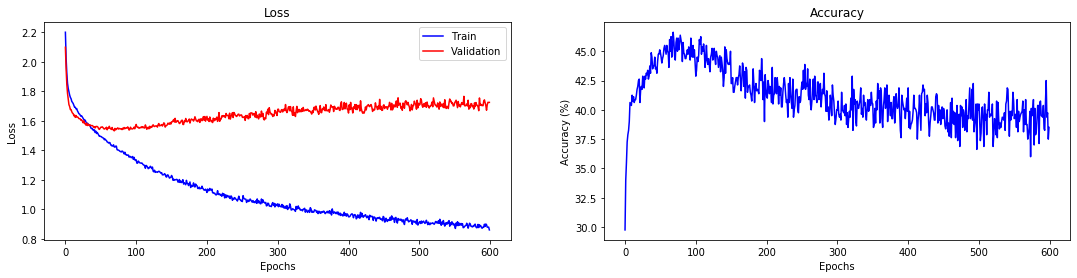

In [11]:
fig = plt.figure()
fig.subplots_adjust(right=2.5)

ax1 = fig.add_subplot(121)
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(train_losses, 'b-', label='Train')
ax1.plot(valid_losses, 'r-', label='Validation')
ax1.legend(loc='upper right')

ax1 = fig.add_subplot(122)
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.plot(accuracies, 'b-')

plt.show()

In [12]:
torch.save(model.state_dict(), './results/mgc_dnn_d_bn_fma.model')

FileNotFoundError: [Errno 2] No such file or directory: './results/mgc_dnn_d_bn_fma.model'

In [ ]:
test_data_batches = data_batcher(test_data, valid_batch_size)
accuracy = test(model, device, test_data_batches)